In [346]:
#importamos las librerias y el archivo con el que vamos a trabajar
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.metrics import f1_score, matthews_corrcoef, classification_report

# Download latest version
url = ('https://raw.githubusercontent.com/malozoyab/fertility/refs/heads/main/fertility.csv')

df = pd.read_csv(url)

In [347]:
#muestra de los datos
df.head()

,Season,Age,Childish diseases,Accident or serious trauma,Surgical intervention,High fevers in the last year,Frequency of alcohol consumption,Smoking habit,Number of hours spent sitting per day,Diagnosis
0,spring,30,no,yes,yes,more than 3 months ago,once a week,occasional,16,Normal
1,spring,35,yes,no,yes,more than 3 months ago,once a week,daily,6,Altered
2,spring,27,yes,no,no,more than 3 months ago,hardly ever or never,never,9,Normal
3,spring,32,no,yes,yes,more than 3 months ago,hardly ever or never,never,7,Normal
4,spring,30,yes,yes,no,more than 3 months ago,once a week,never,9,Altered


In [348]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Season                                 110 non-null    object
 1   Age                                    110 non-null    int64 
 2   Childish diseases                      110 non-null    object
 3   Accident or serious trauma             110 non-null    object
 4   Surgical intervention                  110 non-null    object
 5   High fevers in the last year           110 non-null    object
 6   Frequency of alcohol consumption       110 non-null    object
 7   Smoking habit                          110 non-null    object
 8   Number of hours spent sitting per day  110 non-null    int64 
 9   Diagnosis                              110 non-null    object
dtypes: int64(2), object(8)
memory usage: 8.7+ KB


Tenemos 110 entradas y 10 variables, la variable a predecir sera la de Diagnosis

In [349]:
#Verificar valores nulos
df.isnull().sum()

Season                                   0
Age                                      0
Childish diseases                        0
Accident or serious trauma               0
Surgical intervention                    0
High fevers in the last year             0
Frequency of alcohol consumption         0
Smoking habit                            0
Number of hours spent sitting per day    0
Diagnosis                                0
dtype: int64

No encontramos ningun valor nulo en las variables

In [350]:
# Descripción estadística de las variables numéricas
df.describe()

,Age,Number of hours spent sitting per day
count,110.000000,110.000000
mean,30.163636,10.645455
std,2.240279,32.059745
min,27.000000,1.000000
25%,28.000000,5.000000
50%,30.000000,7.000000
75%,32.000000,9.000000
max,36.000000,342.000000


El maximo numero de horas sentado no puede ser correcto, ya que no puedes estar sentado mas de 24 horas en un día.

In [351]:
df[df['Number of hours spent sitting per day'] >= 24]

,Season,Age,Childish diseases,Accident or serious trauma,Surgical intervention,High fevers in the last year,Frequency of alcohol consumption,Smoking habit,Number of hours spent sitting per day,Diagnosis
50,spring,30,yes,no,yes,more than 3 months ago,once a week,never,342,Normal


Tenemos una entrada con mas de 24 horas sentado, que trataremos mas adelante.

In [352]:
df['Number of hours spent sitting per day'].value_counts()

Number of hours spent sitting per day
5      18
9      17
7      13
8      12
6      12
3      10
11     10
16      4
14      3
10      3
1       2
2       1
342     1
18      1
4       1
13      1
12      1
Name: count, dtype: int64

Mostramos los distintos valores del numero de horas sentado al dia y la cantidad de cada uno.
Los valores van desde 1 a 18 horas.

In [353]:
df.nunique()

Season                                    4
Age                                      10
Childish diseases                         2
Accident or serious trauma                2
Surgical intervention                     2
High fevers in the last year              3
Frequency of alcohol consumption          4
Smoking habit                             3
Number of hours spent sitting per day    17
Diagnosis                                 2
dtype: int64

In [354]:
duplicated = df[df.duplicated()]
print(duplicated)

   Season  Age Childish diseases Accident or serious trauma  \
20   fall   30                no                         no   

   Surgical intervention High fevers in the last year  \
20                   yes       more than 3 months ago   

   Frequency of alcohol consumption Smoking habit  \
20                      once a week         never   

    Number of hours spent sitting per day Diagnosis  
20                                      5    Normal  


Encontramos un valor duplicado, puede ser un valor correcto ya que pueden coincidir varias personas con los mismos habitos, aunque tambien en la recogida de muestras han podido duplicar la entrada, por lo tanto, viendo que tenemos muchos mas datos de diagnosis normal nos podemos permitir el eliminarla.

In [355]:
df = df.drop_duplicates()

In [356]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(df[col].value_counts(), "\n")

Season
spring    38
fall      32
winter    29
summer    10
Name: count, dtype: int64 

Childish diseases
yes    92
no     17
Name: count, dtype: int64 

Accident or serious trauma
no     63
yes    46
Name: count, dtype: int64 

Surgical intervention
no     56
yes    53
Name: count, dtype: int64 

High fevers in the last year
more than 3 months ago    66
no                        30
less than 3 months ago    13
Name: count, dtype: int64 

Frequency of alcohol consumption
once a week             39
hardly ever or never    39
several times a week    24
every day                7
Name: count, dtype: int64 

Smoking habit
never         55
occasional    31
daily         23
Name: count, dtype: int64 

Diagnosis
Normal     87
Altered    22
Name: count, dtype: int64 



Mostramos los valores y cantidad de cada uno en las variables, para hacernos una idea de los datos que tenemos.

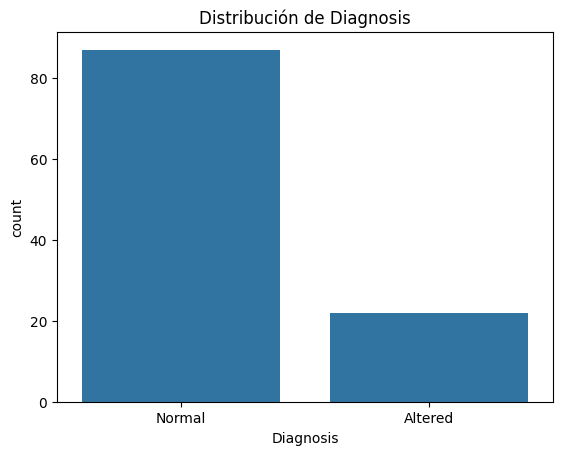

In [357]:
# Distribución de la variable objetivo (Survived)
sns.countplot(x='Diagnosis', data=df)
plt.title('Distribución de Diagnosis')
plt.show()

Como se puede ver, tenemos un desbalanceo de clases, 87 diagnosis normal y 22 diagnosis altered

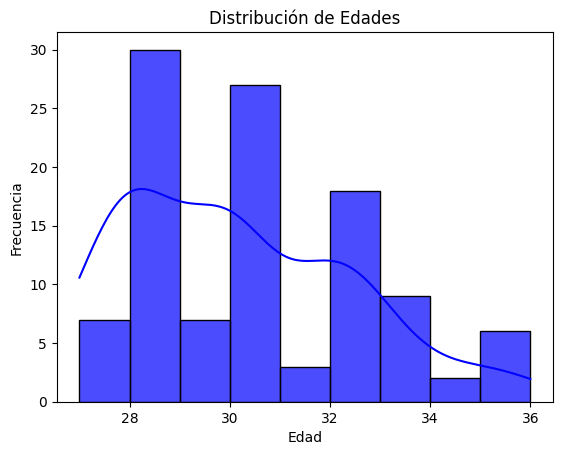

In [358]:
# Distribución de edades
sns.histplot(df['Age'], bins=9, kde=True, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribución de Edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

Representamos la distribución de las edades.

Se observan varios picos en la distribución de las edades, lo que indica que hay grupos de edades con mayor frecuencia en comparación con otros.
Parece haber una ligera asimetría hacia la derecha (cola más larga a la derecha), lo que sugiere que hay más valores concentrados en las edades más bajas.

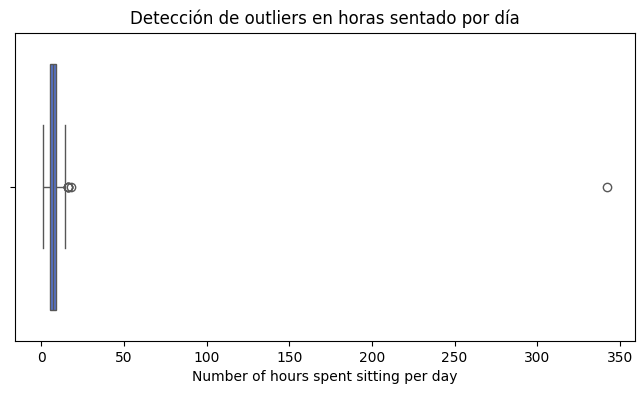

     Season  Age Childish diseases Accident or serious trauma  \
0    spring   30                no                        yes   
50   spring   30               yes                         no   
60     fall   28                no                         no   
66   spring   27               yes                        yes   
70   spring   27               yes                        yes   
104  spring   33                no                         no   

    Surgical intervention High fevers in the last year  \
0                     yes       more than 3 months ago   
50                    yes       more than 3 months ago   
60                     no                           no   
66                     no       less than 3 months ago   
70                     no       less than 3 months ago   
104                    no       more than 3 months ago   

    Frequency of alcohol consumption Smoking habit  \
0                        once a week    occasional   
50                       once

In [359]:
# Visualización de outliers en "Number of hours spent sitting per day"
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["Number of hours spent sitting per day"], color="royalblue")
plt.title("Detección de outliers en horas sentado por día")
plt.show()

# Identificar valores atípicos usando el rango intercuartílico (IQR)
Q1 = df["Number of hours spent sitting per day"].quantile(0.25)
Q3 = df["Number of hours spent sitting per day"].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para valores normales
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Calcular la media de los valores normales y redondear al entero más cercano
mean_value = round(df[(df["Number of hours spent sitting per day"] >= lower_bound) & 
                      (df["Number of hours spent sitting per day"] <= upper_bound)]["Number of hours spent sitting per day"].mean())

# Filtrar valores fuera de los límites
outliers = df[(df["Number of hours spent sitting per day"] < lower_bound) | 
              (df["Number of hours spent sitting per day"] > upper_bound)]

print(outliers)

print('total outliers', outliers.shape[0])

Podemos ver de nuevo el outlier,ademas detectamos que los valores de 16 o por encima los detecta como tal, en este caso los vamos a dejar ya que si podemos pasar ese nº de horas sentados.

In [360]:
# Definir el límite superior del IQR
upper_bound = Q3 + 1.5 * IQR

# Encontrar el valor más alto dentro del IQR (límite superior)
max_valid_value = df.loc[df["Number of hours spent sitting per day"] <= upper_bound, "Number of hours spent sitting per day"].max()

# Reemplazar solo los valores mayores a 24 con el máximo valor válido dentro del IQR
df.loc[df["Number of hours spent sitting per day"] > 24, "Number of hours spent sitting per day"] = max_valid_value

# Comprobar si aún hay valores atípicos mayores a 24
outliers = df[df["Number of hours spent sitting per day"] > 24]
print(outliers)
print('Total outliers:', outliers.shape[0])


Empty DataFrame
Columns: [Season, Age, Childish diseases, Accident or serious trauma, Surgical intervention, High fevers in the last year, Frequency of alcohol consumption, Smoking habit, Number of hours spent sitting per day, Diagnosis]
Index: []
Total outliers: 0


Reemplazamos los valores por encima de 24 con el mayor valor dentro de los valores que no son outliers para no sesgar demasiado el análisis

C:\Users\malozoya\AppData\Local\Temp\ipykernel_14724\1152461591.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Diagnosis", y="Age", data=df, palette="coolwarm", ax=axes[0])
C:\Users\malozoya\AppData\Local\Temp\ipykernel_14724\1152461591.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Diagnosis", y="Number of hours spent sitting per day", data=df, palette="coolwarm", ax=axes[1])


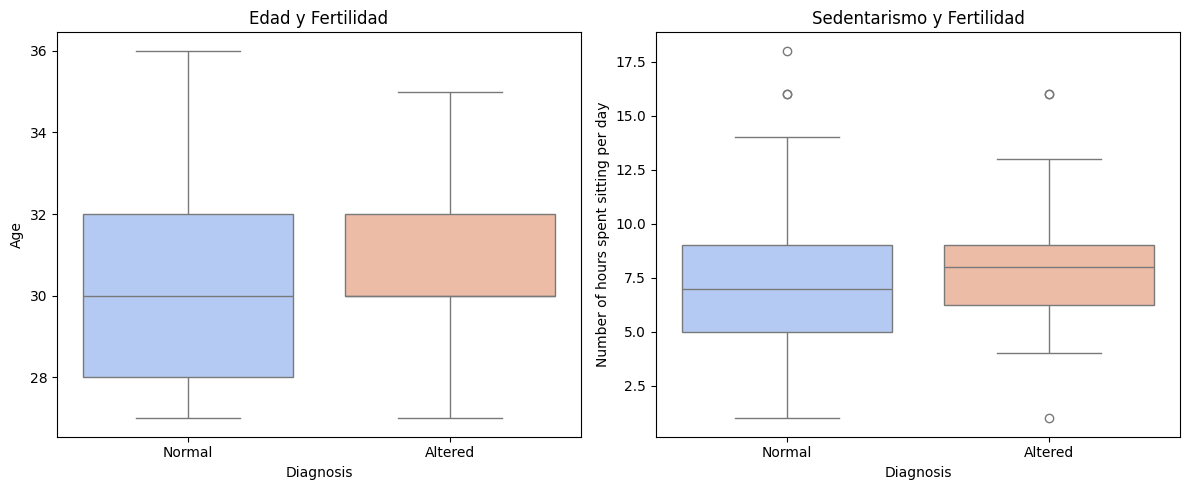

In [361]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x="Diagnosis", y="Age", data=df, palette="coolwarm", ax=axes[0])
axes[0].set_title("Edad y Fertilidad")

sns.boxplot(x="Diagnosis", y="Number of hours spent sitting per day", data=df, palette="coolwarm", ax=axes[1])
axes[1].set_title("Sedentarismo y Fertilidad")

plt.tight_layout()
plt.show()


Estos boxplots comparan la distribución de dos variables (Edad y Horas sentado por día) entre hombres con fertilidad Normal vs. Altered.

Edad vs. Fertilidad

La mediana de edad en el grupo Altered es mayor que en el grupo Normal.
Esto sugiere que, en la muestra, los hombres con diagnóstico de fertilidad alterada tienden a ser mayores que aquellos con diagnóstico normal.
No significa que la edad sea la causa directa, pero sí que existe una relación en el dataset.

Sedentarismo vs. Fertilidad

El boxplot muestra que el grupo Altered tiene una mediana de horas sentado al día más alta que el grupo Normal.
Esto podría señalar que un estilo de vida más sedentario podría estar asociado con una fertilidad alterada.

La visualización sugiere que mayor edad y más horas sentado podrían relacionarse con un diagnóstico de fertilidad alterada.
Importante: estos boxplots solo muestran correlaciones en la muestra analizada. Para confirmar causalidad, haría falta un estudio más profundo.

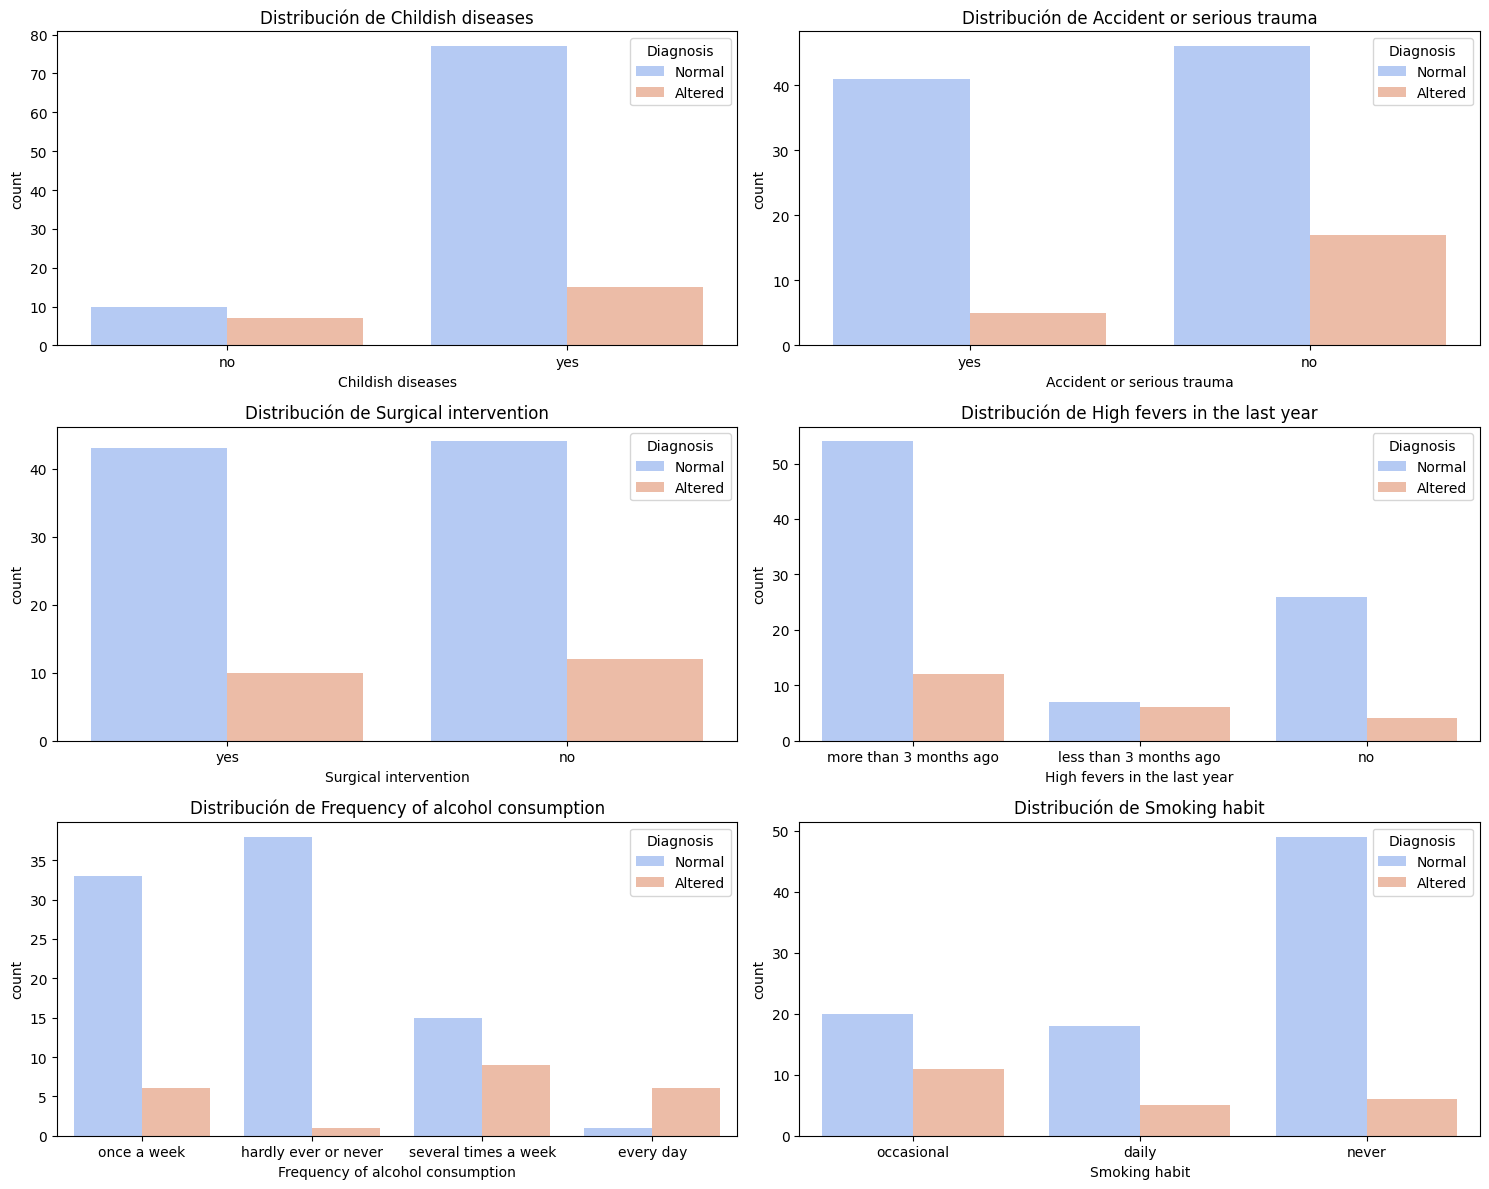

In [362]:
categorical_cols = [
    "Childish diseases", "Accident or serious trauma", "Surgical intervention",
    "High fevers in the last year", "Frequency of alcohol consumption", "Smoking habit"
]

num_cols = 2
num_rows = (len(categorical_cols) + 1) // 2  # Ensures there are 2 charts per row

fig, axes = plt.subplots(nrows=(len(categorical_cols) + 1) // 2, ncols=2, figsize=(15, 12))

for i, col in enumerate(categorical_cols):
    row = i // 2
    col_pos = i % 2
    sns.countplot(data=df, x=col, hue="Diagnosis", ax=axes[i // 2, i % 2], palette="coolwarm")
    axes[i // 2, i % 2].set_title(f"Distribución de {col}")

plt.tight_layout()
plt.show()


Distribución de Childish diseases (Enfermedades infantiles)
Se observa que la mayoría de los participantes han tenido enfermedades infantiles en su infancia.
En ambos grupos, la cantidad de personas que tuvieron enfermedades infantiles es mucho mayor que la de quienes no las tuvieron.
En proporción, parece que el porcentaje de personas con diagnóstico Altered es similar tanto en aquellos que tuvieron enfermedades infantiles como en los que no.
Esto sugiere que las enfermedades infantiles pueden no estar fuertemente relacionadas con la fertilidad alterada.

Accident or serious trauma (Accidentes o traumas graves)
Se observa que hay más individuos con diagnóstico “Normal” en la categoría “no”, pero la proporción de aquellos con diagnóstico “Altered” es más alta en comparación con los que sí sufrieron un accidente.
Esto podría sugerir que no haber tenido un accidente está más asociado con el diagnóstico “Altered” que con el “Normal”, pero esto requeriría mas pruebas.

Surgical intervention (Intervención quirúrgica)
Hay aproximadamente la misma cantidad de personas en las categorías “yes” y “no” en el grupo Normal.
Sin embargo, en el grupo Altered, parece haber un ligero aumento en aquellos que han tenido una intervención quirúrgica.
Esto sugiere que podría haber una relación leve entre haber pasado por una cirugía y un diagnóstico alterado de fertilidad, pero se necesitaría más análisis de las intervenciones realizadas.

High fevers in the last year (Fiebres altas en el último año)
La mayoría de los participantes reportaron haber tenido fiebre hace más de 3 meses.
Un menor número de personas reportó fiebre hace menos de 3 meses o no haber tenido fiebre en el último año.
En términos de diagnóstico, parece que hay una proporción mayor de individuos con diagnóstico Altered entre aquellos que no han tenido fiebre en comparación con los que sí la han tenido hace más de 3 meses. Esto podría indicar que no haber tenido fiebre en el último año está asociado con una menor fertilidad.

Frequency of alcohol consumption (Frecuencia de consumo de alcohol)
La mayor parte de la población consume alcohol “hardly ever or never” o “once a week”.
Dentro de esas categorías, parece haber un porcentaje mayor de diagnóstico Altered en comparación con quienes beben “several times a week” o “every day”. Esto podría indicar que un consumo más frecuente de alcohol no tiene una relación clara con el diagnóstico Altered o que el impacto del alcohol en la fertilidad no es tan fuerte según estos datos.

Smoking habit (Hábito de fumar)
Se observa que la mayoría de los participantes nunca han fumado.
En la categoría “occasional” y “daily”, hay una mayor proporción de personas con diagnóstico Altered, lo que podría sugerir una posible relación entre fumar y la fertilidad alterada.

Los boxplots y los gráficos de barras muestran diferencias entre los grupos, pero no permiten inferir causas directas.
Para validar si ciertas variables afectan significativamente la fertilidad, se deberían hacer análisis estadísticos adecuados.
Algunas variables, como el hábito de fumar o el consumo de alcohol, parecen tener una relación más clara con la fertilidad alterada.
Otras variables, como haber tenido enfermedades infantiles, parecen menos relevantes, pero se necesita análisis adicional para confirmarlo.
Tambien debemos tener en cuenta que tenemos una pequeña muestra de datos, según avance la recogida de datos podremos tener mas información.

Creamos una copia del DataFrame original.
Convierte la columna "Diagnosis" a valores binarios (1 si es "Altered", 0 en caso contrario) y aplicamos codificación one-hot para convertir variables categóricas en columnas binarias

In [363]:
df_encoded = df.copy()  
df_encoded["Diagnosis"] = df_encoded["Diagnosis"].apply(lambda x: 1 if x == "Altered" else 0)
df_encoded = pd.get_dummies(df_encoded)  

Utilizamos Random Forest para analizar la importancia de las variables:

Separamos los datos en características (X) y variable objetivo (y), donde "Diagnosis" es la variable a predecir
Entrenamos un modelo RandomForestClassifier con 100 árboles
Extraemos la importancia de cada característica con feature_importances_
Se normalizan estos valores para destacar la dirección del impacto

Graficamos una visualización con barras de colores:
Barras rojas: variables que se relacionan positivamente con el diagnóstico "Altered" (1)
Barras verdes: variables que se relacionan negativamente (más asociadas con "Normal" o 0)

Este análisis te permite identificar qué variables tienen mayor influencia en la predicción del diagnóstico y en qué dirección.

C:\Users\malozoya\AppData\Local\Temp\ipykernel_14724\621011238.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X.columns, y=normalized_importances, palette=colors)


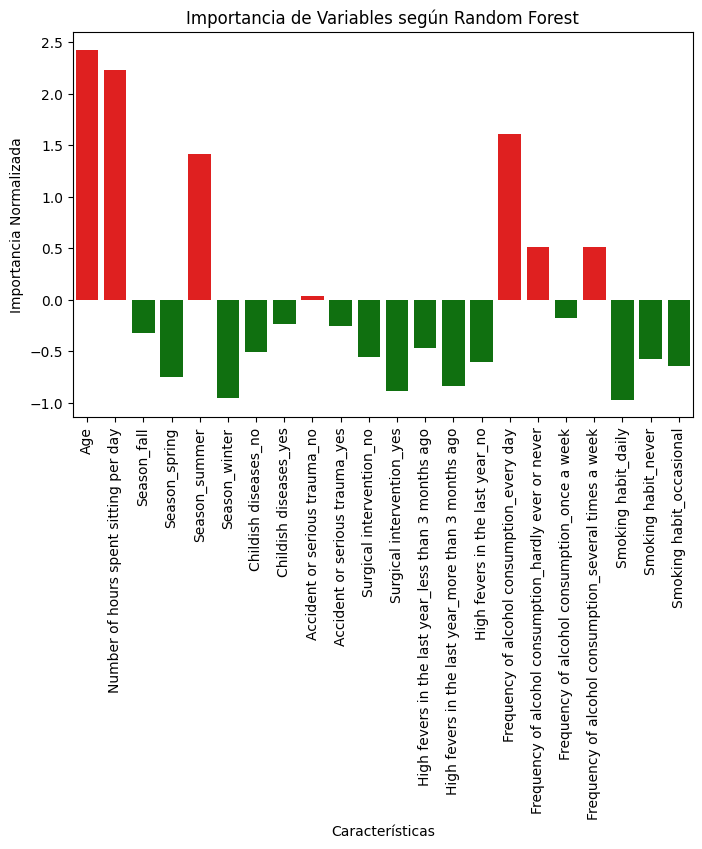

In [364]:
# Dividir datos en X e y
X = df_encoded.drop(columns=["Diagnosis"])
y = df_encoded["Diagnosis"]

# Entrenar el modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Obtener importancia de características
importances = rf.feature_importances_

# Normalizar entre -1 y 1 para resaltar dirección de impacto
normalized_importances = (importances - np.mean(importances)) / np.std(importances)

# Definir colores: rojo para valores positivos (mayor relación con "Altered"), verde para negativos ("Normal")
colors = ["red" if val > 0 else "green" for val in normalized_importances]

# Graficar
plt.figure(figsize=(8, 5))
sns.barplot(x=X.columns, y=normalized_importances, palette=colors)
plt.xticks(rotation=90)
plt.title("Importancia de Variables según Random Forest")
plt.ylabel("Importancia Normalizada")
plt.xlabel("Características")
plt.show()


Algunas observaciones clave del gráfico son:

Edad (Age) y Número de horas sentado por día (Number of hours spent sitting per day) tienen una alta importancia positiva, lo que sugiere que a mayor edad y mayor sedentarismo, hay una mayor probabilidad de tener un diagnóstico de fertilidad alterada.
Frecuencia de consumo de alcohol (Frequency of alcohol consumption) y Hábito de fumar (Smoking habit) también muestran una importancia significativa, con ciertos niveles de consumo de alcohol y fumar ocasionalmente asociados positivamente con la fertilidad alterada.
Algunas variables como Intervención quirúrgica (Surgical intervention) y Fiebres altas en el último año (High fevers in the last year) tienen una importancia negativa, sugiriendo que no tener estas condiciones está más asociado con un diagnóstico normal.


Separamos los datos en características (X) y la variable objetivo (y):
Se dividen los datos en conjuntos de entrenamiento y prueba:
train_test_split() divide los datos con un 80% para entrenamiento y 20% para pruebas
stratify=y mantiene la misma distribución de clases en ambos conjuntos esto es importante para datos desbalanceados.

Convierte los datos a float32:
Esto es necesario para el modelo de red neuronal.

In [365]:
# Dividir datos en X e y
X = df_encoded.drop(columns=["Diagnosis"])
y = df_encoded["Diagnosis"]

# Separar datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

Red neuronal para clasificación binaria:

Crea un modelo secuencial con 3 capas:
Primera capa: 23 neuronas con activación ReLU, recibe los datos.
Segunda capa: 7 neuronas con activación ReLU
Capa de salida: 1 neurona con activación sigmoidea, produce valores entre 0 y 1 para clasificación binaria

Compilamos el modelo con:

Optimizador Adam (ajusta automáticamente la tasa de aprendizaje)
Función de pérdida "binary_crossentropy" (óptima para problemas binarios)
Métrica de evaluación: accuracy, AUC(mas adecuado para clases desbalancedadas)

Entrena el modelo con:
48 épocas de entrenamiento
Lotes (batches) de 6 muestras
Validación en tiempo real usando X_test e y_test

In [366]:
model = keras.Sequential([
    keras.layers.Dense(23, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(7, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", AUC(name='auc')])
history = model.fit(X_train, y_train, epochs=48, batch_size=6, validation_data=(X_test, y_test))


Epoch 1/48


C:\Users\malozoya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7921 - auc: 0.5260 - loss: 0.5223 - val_accuracy: 0.8182 - val_auc: 0.7083 - val_loss: 0.4520
Epoch 2/48
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7869 - auc: 0.5017 - loss: 0.5293 - val_accuracy: 0.8182 - val_auc: 0.7778 - val_loss: 0.4435
Epoch 3/48
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7574 - auc: 0.5558 - loss: 0.5456 - val_accuracy: 0.8182 - val_auc: 0.8194 - val_loss: 0.4368
Epoch 4/48
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7813 - auc: 0.6674 - loss: 0.5098 - val_accuracy: 0.8182 - val_auc: 0.8194 - val_loss: 0.4333
Epoch 5/48
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8516 - auc: 0.5360 - loss: 0.4208 - val_accuracy: 0.8182 - val_auc: 0.8819 - val_loss: 0.4249
Epoch 6/48
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7541 - auc: 0.6491 - loss: 0.5275 - val_accuracy: 0.8182 - val_auc: 0.9097 - val_loss: 0.4430
Epoch 7/48
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 

Predicción:
Realizamos predicciones con el modelo sobre el conjunto de test, devolviendo probabilidades entre 0 y 1. 
Convertimos esas probabilidades en clases binarias. Si la probabilidad es mayor que 0.5, se asigna la clase 1, y si es menor o igual, se asigna la clase 0.

Se calcula el F1-Score, esta medida combina la precisión y el recall en un solo valor. Es útil cuando hay un desequilibrio en las clases. 

Calcula el Matthews Correlation Coefficient (MCC), que es una métrica más robusta para evaluar modelos de clasificación binaria, especialmente en conjuntos de datos desequilibrados.

Se imprime el F1-Score, el MCC y el classification report.

In [367]:
#Calculamos las métricas:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(classification_report(y_test, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
F1-Score: 0.8889
MCC: 0.8692
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.80      1.00      0.89         4

    accuracy                           0.95        22
   macro avg       0.90      0.97      0.93        22
weighted avg       0.96      0.95      0.96        22



El F1-Score es 0.8889, lo que indica que el modelo tiene un buen balance entre precisión y recall para la clase positiva (1).

El Matthews Correlation Coefficient (MCC) es 0.8692, lo que indica una relación bastante fuerte y positiva entre las predicciones y las etiquetas reales.

Precision: La precisión mide la proporción de predicciones positivas correctas respecto al total de predicciones positivas realizadas.
Para la clase 0: 1.00, lo que significa que el modelo acierta un 100% de las veces cuando predice la clase 0.
Para la clase 1: 0.80, lo que significa que el modelo acierta un 80% de las veces cuando predice la clase 1.

Recall: El recall mide la proporción de instancias positivas que fueron correctamente identificadas por el modelo.
Para la clase 0: 0.94, lo que significa que el modelo detecta un 94% de las instancias verdaderas de la clase 0.
Para la clase 1: 1.00, lo que significa que el modelo detecta un 100% de las instancias verdaderas de la clase 1.

F1-Score: es una media armónica entre la precisión y el recall. Los valores de F1 para cada clase indican el balance entre precisión y recall:
Para la clase 0: 0.97.
Para la clase 1: 0.89.

Accuracy: La exactitud del modelo es 0.95, lo que significa que el modelo acierta el 95% de las veces en general.

Macro Average: Es el promedio de las métricas de precisión, recall y F1-Score para todas las clases, sin tener en cuenta el tamaño de las clases. En este caso, el macro promedio de F1-Score es 0.93.

Weighted Average: Es el promedio ponderado de las métricas de precisión, recall y F1-Score, donde las clases con más instancias tienen más peso. En este caso, el promedio ponderado de F1-Score es 0.96.

El modelo muestra un buen desempeño general, especialmente en la predicción de la clase 0. Sin embargo, tiene algo de dificultad con la clase 1. Esto puede ser indicativo de que la clase 1 está menos representada en los datos o que el modelo necesita más ajustes para mejorar la predicción de esa clase.

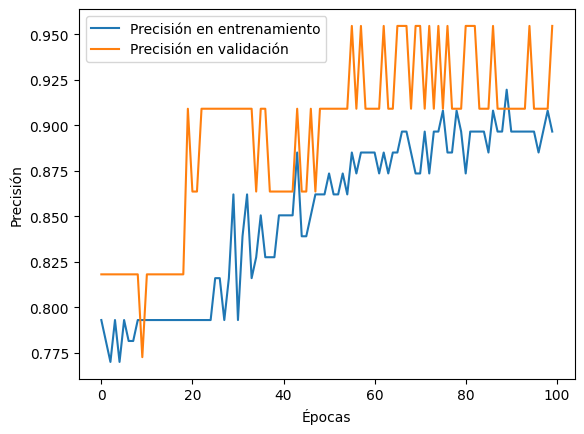

In [210]:
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()